In [1]:
%matplotlib inline

import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"
np.seterr(invalid="ignore")

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
#b = dafPersist.Butler("Cfht/output")
b_branch = dafPersist.Butler("/home/krughoff/testing_4692/testout")

b_master = dafPersist.Butler("../validate_drp_master/Cfht/output")

In [3]:
def median_dists(butler, visit1, visit2, plot=False):
    ccd_list = xrange(1,35)
    all_dists = []
    median_dists = []
    for ccdnum in ccd_list:
        exp1 = butler.get("src", visit=visit1, ccd=ccdnum, immediate=True)
        exp2 = butler.get("src", visit=visit2, ccd=ccdnum, immediate=True)

        calexp_md = butler.get("calexp_md", visit=visit1, ccd=ccdnum, immediate=True)
        calib = afwImage.Calib(calexp_md)
        calib.setThrowOnNegativeFlux(False)
        exp1_mags,_ = calib.getMagnitude(exp1['base_PsfFlux_flux'], exp1['base_PsfFlux_fluxSigma'])

        sel_magcut, = np.where(exp1_mags < 21.0)
        coord1 = SkyCoord(exp1['coord_ra'], exp1['coord_dec'], unit="rad", frame="icrs")
        coord2 = SkyCoord(exp2['coord_ra'], exp2['coord_dec'], unit="rad", frame="icrs")
        idx, chip_dists, _ = coord1.match_to_catalog_sky(coord2)
        pixel_scale = calexp_md.get('CD1_1') * 3600
        dist_sigma = pixel_scale*np.sqrt(2)*np.sqrt(exp1['slot_Centroid_xSigma']**2 +
                                                    exp1['slot_Centroid_ySigma']**2)
        
        flags = exp1["base_PixelFlags_flag_cr"] | exp1["base_PixelFlags_flag_bad"] | \
                exp1["base_PixelFlags_flag_saturated"] | exp1["base_PixelFlags_flag_edge"]
            
        
        sel, = np.where((chip_dists < 1*u.arcsec) & (exp1_mags < 21.0) & (~flags))
        aggregate_dist = np.median(chip_dists[sel])
        #median_dists.append(aggregate_dist.to(u.arcsec).value)
        all_dists.append(chip_dists[sel].to(u.arcsec).value)
        if plot:
            sel_plot, = np.where((chip_dists < 1*u.arcsec) & (exp1_mags < 21.0) & (~flags))
            plt.plot(exp1_mags[sel_plot], chip_dists[sel_plot].to(u.arcsec).value, '.')
            plt.ylabel("Separation (arcsec)")
            plt.xlabel("Magnitude")
            # Normalize by distance sigma
            #plt.plot(exp1_mags[sel_plot], chip_dists[sel_plot].to(u.arcsec).value/dist_sigma[sel_plot], '.')
    return np.array([np.median(x) for x in all_dists]), np.median(np.hstack(all_dists))


0.024408293581


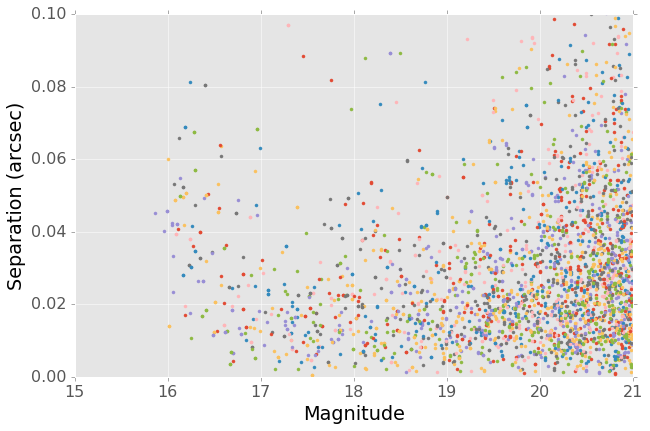

In [4]:
dists_branch, median_branch = median_dists(b_branch, 849375, 850587, plot=True)
plt.ylim(0,0.1)
print median_branch

0.0244601677099


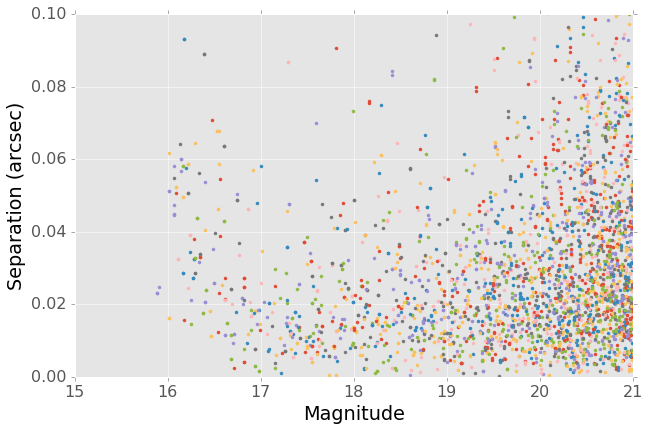

In [5]:
dists_master, median_master = median_dists(b_master, 849375, 850587, plot=True)
plt.ylim(0,0.1)
print median_master

The chip with all the points fainter than 24 is CCD 30.

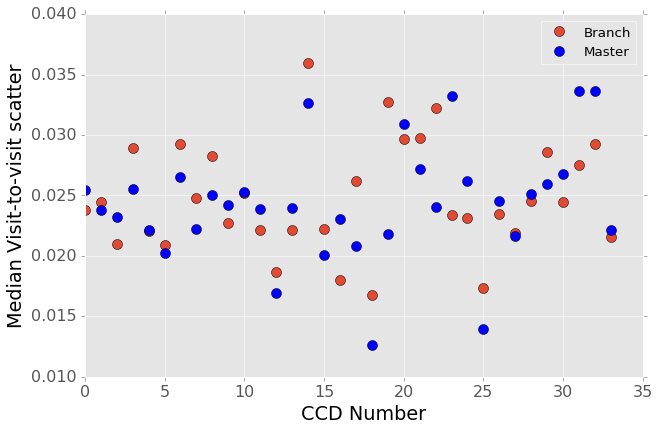

In [6]:

plt.plot(dists_branch, 'o', ms=10, label="Branch")
plt.plot(dists_master, 'bo', ms=10, label="Master")
plt.xlabel("CCD Number")
plt.ylabel("Median Visit-to-visit scatter")
plt.legend(fontsize="small", loc=0, numpoints=1)

#b.template_catalog = b_master.get("src", visit=849375, ccd=ccdnum, immediate=True)
#cmp_catalogs = [b.get("src", visit=850587, ccd=ccdnum, immediate=True),
#                b.get("src", visit=850587, ccd=ccdnum, immediate=True)]

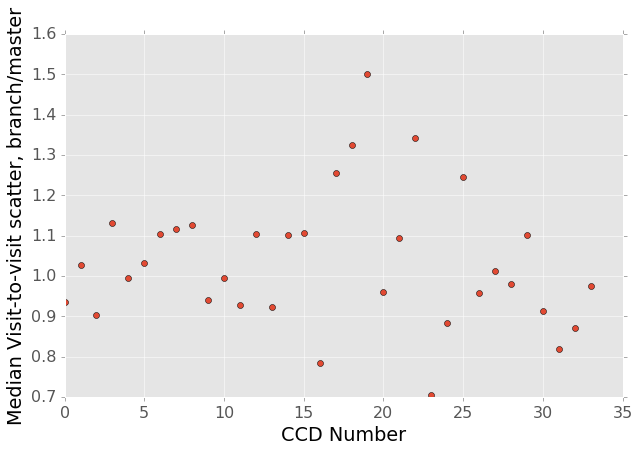

In [7]:
plt.plot(np.array(dists_branch)/np.array(dists_master), 'o')
plt.xlabel("CCD Number")
plt.ylabel("Median Visit-to-visit scatter, branch/master")

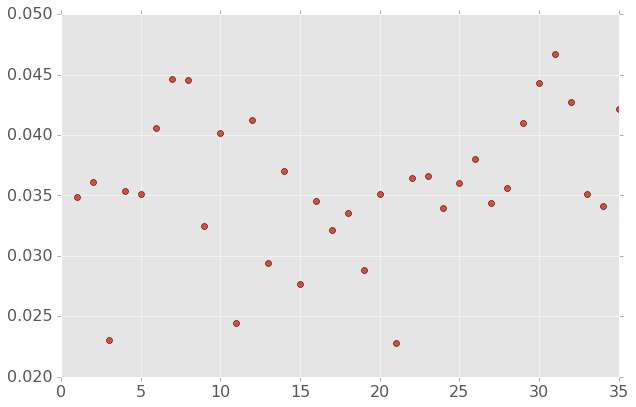

In [8]:
ccd_list = xrange(1,36)
dists = []
# 849375
for ccdnum in ccd_list:
    matches = b_branch.get("srcMatch", visit=850587, ccd=ccdnum)
    dists.append(np.median(matches['distance']))
plt.plot(ccd_list, np.array(dists)*3600*180/np.pi, 'o')